In [1]:
import numpy as np
import mat73
import pandas as pd
from hyperopt import tpe
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.signal import filtfilt,butter,hilbert,convolve2d,convolve
import scipy.io as sio
from Bolu_IFG.utils import get_train_test,decoding,reformat
import nltk
from nltk.stem import WordNetLemmatizer
import hyperopt
import collections
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSSVD,PLSRegression
from multiprocessing import Pool
import enlighten

# Download the CMU Pronouncing Dictionary
nltk.download('cmudict')
# Create a sentence to phoneme dictionary

words_to_phonemes = nltk.corpus.cmudict.dict()

[nltk_data] Downloading package cmudict to /Users/tlc0494/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [3]:
band='high_gamma_band' ## this could be high gamma band or spike band

date = 'Jan05_2024'  # here we have Jan05_2024,
data_path = f'../Bolu_IFG/processed_data/{band}_power/{date}_all_blocks.mat'

try:
    raw_data_jan = pd.DataFrame(sio.loadmat(data_path)['all_data'])
except:
    raw_data_jan = pd.DataFrame(mat73.loadmat(data_path)['all_data'])
date = 'Dec06_2023'  # here we have Jan05_2024, Dec06_2023 data
data_path = f'../Bolu_IFG/processed_data/{band}_power/{date}_all_blocks.mat'

try:
    raw_data_dec = pd.DataFrame(sio.loadmat(data_path)['all_data'])
except:
    raw_data_dec = pd.DataFrame(mat73.loadmat(data_path)['all_data'])

## Here we would like to do some trial cleaning and channel cleaning

rejected_channels: [ 3 62] 

rejected_trials: [  0  11  32  43  65  91 103 126 127 130 138 162 163 164 184 185 190 191
 199 212 220 230 246 269 282 300]


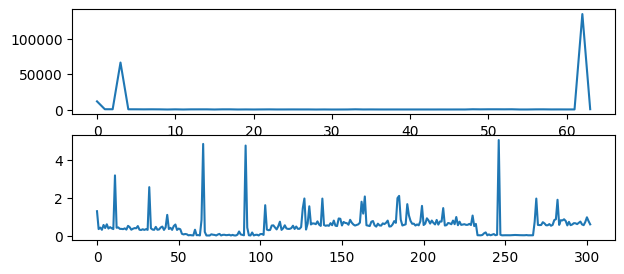

In [4]:
# concatenate data
raw_data = pd.concat([raw_data_jan,raw_data_dec])

## throw away the bad trials: only used in Jan data
## hard coded here
#bad_trials=[27,30,34,50,53,55,56,58,60,62,65,66,67,68,69,83,85,94]
#raw_data=raw_data.drop(raw_data.index[bad_trials])
all_data = raw_data[1].to_list()
## channel cleaning
channel_std=raw_data[0].to_list()[0]
channel_std_std=channel_std.std()
reject_channels=np.where(channel_std>channel_std.std())[0]
channel_clean_data=[np.delete(a,reject_channels,axis=0) for a in all_data]
### trial cleaning
trial_std=np.array([t.mean(axis=0).std() for t in channel_clean_data])
reject_trials=np.where(trial_std>1.5*trial_std.std())[0]
# a bit too complicate but i don't know any better method so far

raw_data=raw_data.drop(raw_data.index[reject_trials])
clean_data=[np.delete(a,reject_channels,axis=0) for a in raw_data[1].to_list()]
print(f"rejected_channels: {reject_channels} \n")
print(f"rejected_trials: {reject_trials}")

fig,ax=plt.subplots(2,1,figsize=(7,3))
ax[0].plot(channel_std)
ax[1].plot(trial_std)
plt.show()

In [5]:
# process the labels
correct_label = raw_data[10].to_numpy()
answered_label = raw_data[11].to_numpy()
answered_words = raw_data[8].to_numpy()
#answered_semantic_label=raw_data[12].to_numpy()
correct_label = np.array([a[0] for a in correct_label])
answered_label = np.array([a[0] for a in answered_label])
#answered_semantic_label=np.array([a[0] if a!=np.NaN else np.NaN for a in answered_semantic_label])
lemmatizer = WordNetLemmatizer()
answered_lexical_item = np.array([lemmatizer.lemmatize(a[0][0][0], pos='v') for a in answered_words])
first_phonemes = np.array([words_to_phonemes[a][0][0] for a in answered_lexical_item])

# process the time stamps
phrase_on = raw_data[2].to_numpy()
word_on = raw_data[4].to_numpy()
voice_on = raw_data[6].to_numpy()
voice_off = raw_data[7].to_numpy()

phrase_on = np.array([a[0][0] for a in phrase_on])
word_on = np.array([a[0][0] for a in word_on])
voice_on = np.array([a[0][0] for a in voice_on])
voice_off = np.array([a[0][0] for a in voice_off])

# recording frequency rate
fs = 2000
print(collections.Counter(answered_lexical_item))
#print(collections.Counter(answered_semantic_label))
print(collections.Counter(first_phonemes))
print(collections.Counter(answered_label))

Counter({'rub': 22, 'tip': 21, 'bake': 16, 'boot': 15, 'keep': 13, 'date': 12, 'pass': 12, 'talk': 12, 'pack': 11, 'rap': 11, 'call': 10, 'dock': 8, 'cry': 7, 'snore': 5, 'run': 5, 'chew': 5, 'fail': 4, 'jump': 4, 'kick': 4, 'need': 4, 'look': 4, 'lick': 4, 'grab': 4, 'wipe': 4, 'star': 3, 'vote': 3, 'see': 3, 'cut': 3, 'heal': 3, 'bite': 3, 'mix': 3, 'chase': 3, 'stare': 3, 'kiss': 3, 'punch': 2, 'write': 2, 'peek': 2, 'yell': 1, 'type': 1, 'hop': 1})
Counter({'K': 40, 'R': 40, 'B': 34, 'T': 34, 'P': 27, 'D': 20, 'S': 14, 'L': 8, 'CH': 8, 'F': 4, 'JH': 4, 'N': 4, 'HH': 4, 'G': 4, 'W': 4, 'V': 3, 'M': 3, 'Y': 1})
Counter({'2': 121, '1': 71, '3': 64})


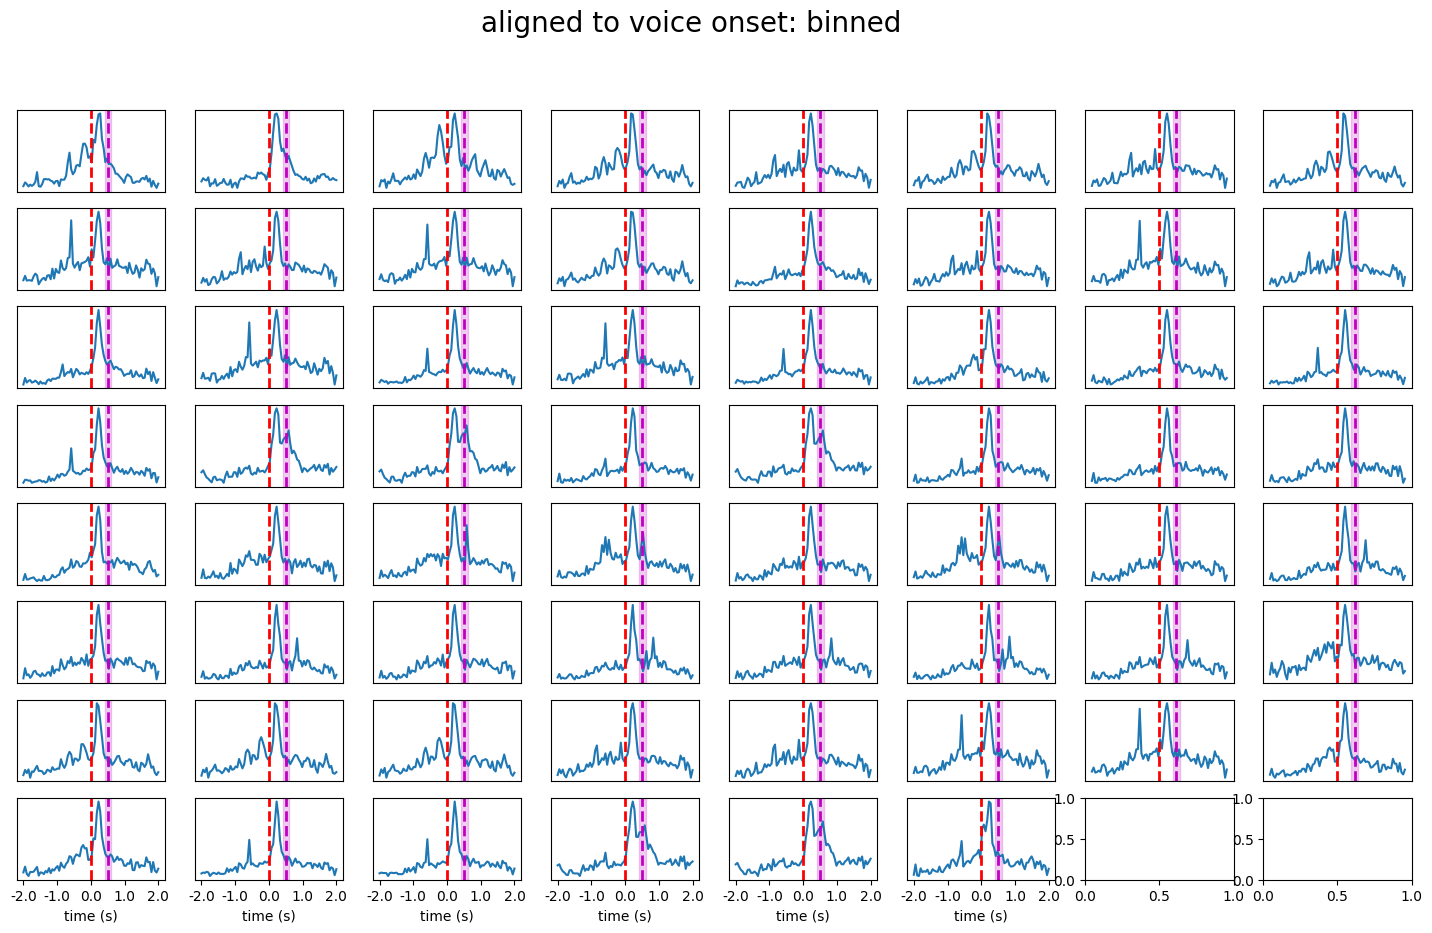

In [6]:
# define the decoding time range and bin the data
# aligning to the voice onset

back=2 # looking back 3 seconds before onset
forward=2 # looking forward 1 second after onset
bin_size=0.05 # s
adjusted_fs=1/bin_size # Hz
processed_data_voice_on=[trial[:,int(voice_on[i]*fs-back*fs) : int(voice_on[i]*fs+forward*fs)] for i,trial in enumerate(clean_data)]
n_channels=processed_data_voice_on[0].shape[0]
n_trials_total=len(processed_data_voice_on)
binned_data_voice_on=[trial.reshape(n_channels,int(bin_size*fs),-1,order='F').mean(axis=1) for trial in processed_data_voice_on]
binned_data_voice_on_averaged=np.mean(binned_data_voice_on,axis=0)
n_bins=binned_data_voice_on_averaged.shape[-1]

ave_voice_on=back

ave_phrase_on=-(voice_on-phrase_on).mean()+ave_voice_on
std_phrase_on=(voice_on-phrase_on).std()

ave_word_on=-(voice_on-word_on).mean()+ave_voice_on
std_word_on=(voice_on-word_on).std()

ave_voice_off=-(voice_on-voice_off).mean()+ave_voice_on
std_voice_off=(voice_off-voice_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(n_channels):
    ax[i//8,i%8].plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,(back+forward)*adjusted_fs,5), [f"{i:0.1f}" for i in np.linspace(-back,forward,5)])
        ax[i//8,i%8].set_xlabel("time (s)")
    
    ax[i//8,i%8].axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_word_on * adjusted_fs - std_word_on * adjusted_fs, ave_word_on * adjusted_fs + std_word_on * adjusted_fs, color='g', alpha=0.2)
    #ax[i//8,i%8].axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to voice onset: binned",fontsize=20)
plt.show()

## Build a decoder for each bin for every time bin

In [ ]:
#### Syntax labels ####
# 1: past
# 2: present
# 3: present + s 
data_to_use=np.swapaxes(np.array(binned_data_voice_on)[answered_label!='1',:,:],1,2)
labels_to_use=answered_label[answered_label!='1']

#### first phoneme labels ####
# data_to_use=np.swapaxes(np.array(binned_data_voice_on)[(first_phonemes=='T')|(first_phonemes=='K'),:,:],1,2)
# labels_to_use=first_phonemes[(first_phonemes=='T')|(first_phonemes=='K')]


#### Feature extraction method
#extractor=NCA(n_components=10)
extractor=PCA(n_components=10)
#extractor=PLSRegression(n_components=10)

# define how many bins we want in each feature
n_bins_per_feature=15

# reformat the data: for each time bin we include n_bins_per_feature of history
X=reformat(data_to_use,n_bins_per_feature) # data is a list

#### Choose a decoder 
#decoder=SVC(C=10**4.57,kernel='rbf',gamma=10**2.05,probability=False)
decoder=SVC(class_weight='balanced')
#decoder=LinearSVC(class_weight='balanced', dual='auto')
#decoder=LogisticRegression()
#decoder=RandomForestClassifier(n_estimators=100, max_depth=5)


#### Start decoding
n_repeat=50
averaged_accuracy=[]
averaged_chance=[]
# GUI for process visualization

manager = enlighten.get_manager()
ticks = manager.counter(total=n_repeat, desc="Num. repeat", unit="repeats", color="red")
#tocks = manager.counter(total=len(X), desc="time bin processed", unit="tocks", color="blue")
for j in range(n_repeat):
    accuracy=[]
    chance=[]
    for n_bin in range(len(X)):
        # sample the train and test set
        X_train, X_test, y_train, y_test =get_train_test(X[n_bin],labels_to_use,train=0.8)
        
        # extract the features
        extractor.fit(X_train,y_train)
        X_train_low=extractor.transform(X_train)
        X_test_low=extractor.transform(X_test)
        
        # classification
        decoder.fit(X_train_low, y_train) 
        y_predict=decoder.predict(X_test_low)
        
        # calculate the accuracy
        correct=np.sum(y_predict==y_test)
        accuracy.append(correct/len(y_predict))
                
        # train a decoder using shuffled data
        np.random.shuffle(y_train)
        decoder.fit(X_train_low, y_train)
        y_predict=decoder.predict(X_test_low)

        # calculate the chance accuracy
        correct=np.sum(y_predict==y_test)
        chance.append(correct/len(y_predict)) 
        
        #tocks.update()
    ticks.update()
    averaged_accuracy.append(accuracy)
    averaged_chance.append(chance)

In [ ]:
# stat check
from scipy.stats import ttest_ind, ttest_rel,ttest_1samp,false_discovery_control,sem,t
import scipy.stats as stats
def get_the_star(p):
    # input p value and output the starts or n.s.
    if p < 0.005:
        sig_symbol = '*'
    elif p < 0.01:
        sig_symbol = '*'
    elif p < 0.05:
        sig_symbol = '*'
    elif p > 0.05:
        sig_symbol=''
    return sig_symbol

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
averaged_accuracy=np.array(averaged_accuracy)
averaged_chance=np.array(averaged_chance)
all_p=[ttest_ind(aa,ac,equal_var=False,alternative='greater')[1] for aa,ac in zip(averaged_accuracy.T,averaged_chance.T)]
all_p=false_discovery_control(all_p,method='by')
#p_illustration=[get_the_star(p) for p in all_p]


# calcuate the standard error and the confidence interval
mean_chance=np.mean(averaged_chance,axis=0)
mean_accuracy = np.mean(averaged_accuracy,axis=0)
standard_error_accuracy = sem(averaged_accuracy,axis=0)
standard_error_chance = sem(averaged_chance,axis=0)

# Calculate the confidence interval
confidence_interval_accuracy =np.array([t.interval(1-0.025/n_bins, len(averaged_accuracy[:,i])-1, loc=mean_accuracy[i], scale=standard_error_accuracy[i]) for i in range(n_bins)])
confidence_interval_chance =np.array([t.interval(1-0.025/n_bins, len(averaged_chance[:,i])-1, loc=mean_chance[i], scale=standard_error_chance[i]) for i in range(n_bins)])

accuracy_stats=np.array([mean_confidence_interval(averaged_accuracy[:,i],0.975) for i in range(n_bins)])
chance_stats=np.array([mean_confidence_interval(averaged_chance[:,i],0.975) for i in range(n_bins)])
# calculating the empirical distribution
alpha = 2.5
#percentile_bybin = np.percentile(averaged_accuracy,alpha,axis=0)
#p_illustration=['*' if 0.05<percentile_bybin[i] else '' for i in range(n_bins)]

percentile_bybin = np.percentile(averaged_chance,100-alpha,axis=0)
p_illustration=['*' if mean_accuracy[i]>percentile_bybin[i] else '' for i in range(n_bins)]


In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
#                confidence_interval_chance[:,0]-0.03,
#               confidence_interval_chance[:,1]-0.03,alpha=0.2,color='orange')
                accuracy_stats[:,1],accuracy_stats[:,2],alpha=0.2)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),mean_accuracy,lw=3)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),mean_chance,lw=2,linestyle='--',color='orange')
#ax.axhline(0.5,lw=2,linestyle='--',color='orange')

#ax.boxplot(averaged_accuracy_.T,positions=np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),showfliers=False)
#ax2=ax.twinx()
#ax2.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged.mean(axis=0),c='grey',linestyle='--')
ax.axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
# ax.axvspan(ave_word_on * adjusted_fs - std_word_on * adjusted_fs, ave_word_on * adjusted_fs + std_word_on * adjusted_fs, color='g', alpha=0.2)
# ax.axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
ax.axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
ax.axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
ax.set_xticks(np.linspace(0,len(accuracy),10), [f"{i:0.1f}" for i in np.linspace(-back,forward,10)])
ax.set_ylim([0.3,0.8])
ax.set_xlabel("time (s)")
ax.set_ylabel("accuracy")
#ax2.set_ylabel("zscored activity (a.u.)")

for label, loc in zip(p_illustration,np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins)):
    ax.text(loc, 0.4, label, ha='center', va='center')
plt.show()

 ## decoding aligning to word onset

In [9]:
# # define the decoding time range and bin the data
# # aligning to the voice onset
# 
# back=0 # looking back 3 seconds before onset
# forward=4 # looking forward 1 second after onset
# bin_size=0.05 # s
# adjusted_fs=1/bin_size # Hz
# processed_data_word_on=[trial[:,int(word_on[i]*fs-back*fs) : int(word_on[i]*fs+forward*fs)] for i,trial in enumerate(clean_data)]
# n_channels=processed_data_word_on[0].shape[0]
# n_trials_total=len(processed_data_word_on)
# binned_data_word_on=[trial.reshape(n_channels,int(bin_size*fs),-1,order='F').mean(axis=1) for trial in processed_data_word_on]
# binned_data_word_on_averaged=np.mean(binned_data_word_on,axis=0)
# n_bins=binned_data_word_on_averaged.shape[-1]
# 
# ave_word_on=back
# 
# ave_phrase_on=-(word_on-phrase_on).mean()+back
# std_phrase_on=(word_on-phrase_on).std()
# 
# ave_voice_on=(voice_on-word_on).mean()+back
# std_voice_on=(voice_on-word_on).std()
# 
# ave_voice_off=-(word_on-voice_off).mean()+back
# std_voice_off=(voice_off-voice_on).std()
# 
# fig,ax=plt.subplots(8,8,figsize=(18,10))
# for i in range(n_channels):
#     ax[i//8,i%8].plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_word_on_averaged[i])
#     ax[i//8,i%8].set_yticks([])
#     if i//8!=7:   
#         ax[i//8,i%8].set_xticks([])
#     else:
#         ax[i//8,i%8].set_xticks(np.linspace(0,(back+forward)*adjusted_fs,5), [f"{i:0.1f}" for i in np.linspace(-back,forward,5)])
#         ax[i//8,i%8].set_xlabel("time (s)")
#     
#     ax[i//8,i%8].axvspan(ave_voice_on * adjusted_fs - std_voice_on * adjusted_fs, ave_voice_on * adjusted_fs + std_voice_on * adjusted_fs, color='r', alpha=0.2)
#     ax[i//8,i%8].axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
#     ax[i//8,i%8].axvspan(ave_phrase_on * adjusted_fs - std_phrase_on * adjusted_fs, ave_phrase_on * adjusted_fs + std_phrase_on * adjusted_fs, color='k', alpha=0.2)
#     ax[i//8,i%8].axvline(ave_phrase_on * adjusted_fs, color='k', linestyle='--', linewidth=2)
#     ax[i//8,i%8].axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
#     ax[i//8,i%8].axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
#     ax[i//8,i%8].axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
# plt.suptitle("aligned to voice onset: binned",fontsize=20)
# plt.show()

In [10]:
# # build a decoder using PCs and multiple bins
# # build decoder for each bin
# 
# #### syntax labels
# data_to_use=np.swapaxes(np.array(binned_data_word_on)[answered_label!='1',:,:],1,2)
# labels_to_use=answered_label[answered_label!='1']


# # feature extraction
# #extractor=NCA(n_components=10)
# extractor=PCA(n_components=10)

# # define how many bins we want in each feature
# n_bins_per_feature=8
# # ## perform PCA
# # n_PC=30
# # pca=PCA(n_components=n_PC)
# # pca.fit(data_to_use.reshape(-1,n_channels))
# # reduced_data=(pca.transform(data_to_use.reshape(-1,n_channels))/pca.singular_values_).reshape(-1,n_bins,n_PC)
# reduced_data=data_to_use
# # reformat the data
# X_=reformat(reduced_data,n_bins_per_feature) # data is a list
# 
# ### start decoding
# #decoder=SVC(C=10**4.57,kernel='rbf',gamma=10**2.05,probability=False)
# decoder=SVC(class_weight='balanced')
# 
# #decoder=LinearSVC()
# #decoder=LogisticRegression()
# #decoder=RandomForestClassifier(n_estimators=100, max_depth=5)
# averaged_accuracy=[]
# averaged_chance=[]
# for j in range(50):
#     accuracy=[]
#     chance=[]
#     for n_bin in range(len(X_)):
#         X_train, X_test, y_train, y_test =get_train_test(X_[n_bin],labels_to_use,train=0.8)
#         
#         # extract the features
#         feature_extractor=extractor.fit(X_train,y_train)
#         X_train_low=feature_extractor.fit_transform(X_train,y_train)
#         X_test_low=feature_extractor.transform(X_test)
#         
#         # classification
#         decoder.fit(X_train_low, y_train)
#         y_predict=decoder.predict(X_test_low)
#         correct=np.sum(y_predict==y_test)
#         accuracy.append(correct/len(y_predict))
#                 
#         # produce the chance
#         #np.random.shuffle(X_train_low.T)
#         np.random.shuffle(y_train)
#         decoder.fit(X_train_low, y_train)
#         y_predict=decoder.predict(X_test_low)
#         
#         #np.random.shuffle(y_test)
#         # calculate the accuracy
#         correct=np.sum(y_predict==y_test)
#         chance.append(correct/len(y_predict))
# 
#         
#     averaged_accuracy.append(accuracy)
#     averaged_chance.append(chance)
# 


In [11]:
# fig,ax=plt.subplots(1,1,figsize=(8,4))
# ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
#                 np.mean(averaged_accuracy,axis=0)-np.std(averaged_accuracy,axis=0),
#                np.mean(averaged_accuracy,axis=0)+np.std(averaged_accuracy,axis=0),alpha=0.2)
# ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_accuracy,axis=0),lw=3)
# ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_chance,axis=0),lw=2,linestyle='--',color='orange')
# ax2=ax.twinx()
# ax2.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_word_on_averaged.mean(axis=0),c='grey',linestyle='--')
# ax.axvspan(ave_voice_on * adjusted_fs - std_voice_on * adjusted_fs, ave_voice_on * adjusted_fs + std_voice_on * adjusted_fs, color='r', alpha=0.2)
# ax.axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
# ax.axvspan(ave_phrase_on * adjusted_fs - std_phrase_on * adjusted_fs, ave_phrase_on * adjusted_fs + std_phrase_on * adjusted_fs, color='k', alpha=0.2)
# ax.axvline(ave_phrase_on * adjusted_fs, color='k', linestyle='--', linewidth=2)
# ax.axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
# ax.axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
# ax.axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
# ax.set_xticks(np.linspace(0,len(accuracy),7), [f"{i:0.1f}" for i in np.linspace(-back,forward,7)])
# #ax.set_ylim([0.3,0.7])
# ax.set_xlabel("time (s)")
# ax.set_ylabel("accuracy")
# ax2.set_ylabel("zscored activity (a.u.)")
# plt.show()